In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sdv
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.base import clone
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import os
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.neural_network import MLPRegressor
import keras
from keras import layers
from keras import models
import random
import shap
from shap import DeepExplainer
import random

In [601]:
# Initiate Shap visualization
shap.initjs()

In [538]:
# Read the data
data_sheet = pd.read_excel("Data sheet compile cleaned 17.8.23.xlsx")
data_sheet = data_sheet[["Ethnicity","Age",
                         "Gender", "Height (cm)",
                         "Weight (kg)", "BMI",
                         "Clicking", "Lockout",
                         "Jaw pain (in last 2 years)",
                         "Jaw Injuries", "Jaw clenching",
                         "Bruxism", "Sleep apnoea/snoring",
                         "nail or object biting",
                         "Dry/ sticky mouth", "chapped lips",
                         "increased thirst", "dysphagia",
                         "Dental filling in 2 years",
                         "RCTs/crowns in 2 years",
                         "3rd molars extracted",
                         "Orthodontic treatment",
                         "blocked nose", "Lisp",
                         "Stammering", "Vit D deficiency",
                         "Recurrent sinus infections",
                         "Asthma",
                         "Endocrine modifiers (Diabetes, PCOS, Ca Breast)",
                         "Hypertension or high cholesterol",
                         "Inflammatory disorders (arthritis or eczyma)",
                         "Mental health modifiers (stress, depression, anxiety, ADHD)",
                         "Long term medication taken for condition",
                         "Sinus surgery (adenoid or septal)"]].copy()

data_two = pd.read_excel("Biopak data compiled final 1-70 v2.xlsx")

# List of specific features/columns to select
selected_columns = [
    'Canine-canine maxilla',
    'Molar - molar maxilla ',
    'Arch perimeter maxilla',
    'Canine-canine mandible',
    'Molar - molar mandible',
    'Arch perimeter mandible',
    'Overbite',
    'Overjet ',
    'ROM vertical',
    'ROM MAP',
    'ROM Lateral left',
    'ROM Lateral right',
    'ROM Slant',
    'Habitual Head tilt degree',
    'Head tilting direction',
    'Soft tissue Lateral left',
    'Soft tissue Lateral right',
    'chewing left side vertical',
    'chewing left side protrusion',
    'chewing left side Lateral left',
    'chewing left side Lateral right',
    'chewing right side vertical',
    'chewing right side protrusion',
    'chewing right side Lateral left',
    'chewing right side Lateral right',
    'chewing normal side vertical',
    'chewing normal  protrusion',
    'chewing normal side Lateral left',
    'chewing normal side Lateral right',
    'EMG clench TA-R',
    'EMG clench TA-L',
    'EMG clench MM-R',
    'EMG clench MM-L',
    'EMG max TA-R',
    'EMG max TA-L',
    'EMG max MM-R',
    'EMG max MM-L',
    'JVA MMO left integral',
    'JVA MMO left Integral <300Hz',
    'JVA MMO left Integral >300Hz',
    'JVA MMO left Integral ratio',
    'JVA MMO left peak amplitude',
    'JVA MMO left peak frequency',
    'JVA MMO left median frequency',
    'JVA MMO right integral',
    'JVA MMO right Integral <300Hz',
    'JVA MMO right Integral >300Hz',
    'JVA MMO right Integral ratio',
    'JVA MMO right peak amplitude',
    'JVA MMO right peak frequency',
    'JVA MMO right median frequency',
    'JVA MLE left integral',
    'JVA MLE left Integral <300Hz',
    'JVA MLE left Integral >300Hz',
    'JVA MLE left Integral ratio',
    'JVA MLE left peak amplitude',
    'JVA MLE left peak frequency',
    'JVA MLE left median frequency',
    'JVA MLE right integral',
    'JVA MLE right Integral <300Hz',
    'JVA MLE right Integral >300Hz',
    'JVA MLE right Integral ratio',
    'JVA MLE right peak amplitude',
    'JVA MLE right peak frequency',
    'JVA MLE right median frequency',
    'JVA MAP left integral',
    'JVA MAP left Integral <300Hz',
    'JVA MAP left Integral >300Hz',
    'JVA MAP left Integral ratio',
    'JVA MAP left peak amplitude',
    'JVA MAP left peak frequency',
    'JVA MAP left median frequency',
    'JVA MAP right integral',
    'JVA MAP right Integral <300Hz',
    'JVA MAP right Integral >300Hz',
    'JVA MAP right Integral ratio',
    'JVA MAP right peak amplitude',
    'JVA MAP right peak frequency',
    'JVA MAP right median frequency',
    'Fricative vertical',
    'Fricative protrusion',
    'Fricative Lateral left',
    'Fricative Lateral right',
    'Sibilant vertical',
    'Sibilant protrusion',
    'Sibilant Lateral left',
    'Sibilant Lateral right',
    'TH phonetics vertical',
    'TH phonetics protrusion',
    'TH phonetics Lateral left',
    'TH phonetics Lateral right',
    'BP phonetics vertical',
    'BP phonetics protrusion',
    'BP phonetics Lateral left',
    'BP phonetics Lateral right',
    '60s vertical',
    '60s protrusion',
    '60s Lateral left',
    '60s Lateral right',
    'Freeway space'
]
data_two = data_two[selected_columns].copy()

In [539]:
def add_quotients(muscle, data):
    intensity_quotients = pd.read_csv(f"quotients/{muscle}/quotient_intensity.csv")
    duration_quotients = pd.read_csv(f"quotients/{muscle}/quotient_duration.csv")
    temp_data_intensity = intensity_quotients.copy()
    temp_data_duration = duration_quotients.copy()
    temp_data_intensity.columns = [f"{muscle}_intensity_" + name
                                for name in temp_data_intensity.columns]
    temp_data_duration.columns = [f"{muscle}_duration_" + name
                                for name in temp_data_duration.columns]
    
    indices_to_insert_nan = [1, 40, 42, 60]

    # Insert NaN values without replacing existing values
    for index in indices_to_insert_nan:
        temp_data_intensity = pd.concat([temp_data_intensity.iloc[:index],
                                        pd.DataFrame([[np.nan] * len(temp_data_intensity.columns)],
                                                    columns=temp_data_intensity.columns),
                                                    temp_data_intensity.iloc[index:]],
                                                    ignore_index=True).copy()
        temp_data_duration = pd.concat([temp_data_duration.iloc[:index],
                                        pd.DataFrame([[np.nan] * len(temp_data_duration.columns)],
                                                    columns=temp_data_duration.columns),
                                                    temp_data_duration.iloc[index:]],
                                                    ignore_index=True).copy()
        
    # Add quotients to JVA data
    new_data = pd.concat([data, temp_data_intensity], axis=1)
    new_data = pd.concat([new_data, temp_data_duration], axis=1)

    return new_data

In [540]:
# Form entire dataset
combined_dataset = pd.concat([data_sheet,
                              data_two], axis=1)

# Add quotients
for muscle in ["mmo", "mle", "map"]:
    combined_dataset = add_quotients(muscle,
                                     combined_dataset).copy()
    
# Drop rows with NAs
combined_dataset.dropna(inplace=True)


In [541]:
# Function to remove features with 0 variance (constant value features)
def get_const_value_features_to_drop(df):
    return [e for e in df.columns if df[e].nunique() == 1]

features_to_drop = \
    get_const_value_features_to_drop(combined_dataset)
combined_dataset.drop(columns=features_to_drop, 
                      inplace=True)

# turn all categorical values to lower case for consistency
# Convert all entries to lowercase
combined_dataset = \
    combined_dataset.applymap(
        lambda x: x.lower() if isinstance(x, str) else x).copy()

# Remove all leading and trailing whitespaces
combined_dataset = \
    combined_dataset.applymap(
        lambda x: x.strip() if isinstance(x, str) else x).copy()

/var/folders/d7/ws_j0w7s5fddwxs6dv1374lw0000gn/T/ipykernel_35089/4006963973.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_dataset.applymap(
/var/folders/d7/ws_j0w7s5fddwxs6dv1374lw0000gn/T/ipykernel_35089/4006963973.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_dataset.applymap(


In [542]:
# Select only categorical features
categorical_df = combined_dataset.select_dtypes(include='object').copy()
categorical_columns = categorical_df.columns

In [543]:
# Fix last categorical column (convert righht to right)
combined_dataset[categorical_columns[-1]] = \
    combined_dataset[categorical_columns[-1]].map(
        lambda x: "right" if x == "righht" else x).copy()

In [544]:
# Select only categorical features
categorical_df = combined_dataset.select_dtypes(include='object').copy()
categorical_columns = categorical_df.columns

# Verify all categorical columns again
for column in categorical_columns:
    print(categorical_df[column].unique())

['caucasian' 'asian' 'indian' 'hispanic']
['male' 'female']
['no' 'yes']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['yes' 'no']
['yes' 'no']
['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['left' 'straight' 'right']


In [545]:
# Remove participant with an ethnicity of hispanic
combined_dataset['Ethnicity'] = combined_dataset['Ethnicity'].map(
    lambda x: np.nan if x == "hispanic" else x)
combined_dataset.dropna(inplace=True)

In [546]:
combined_dataset['Ethnicity'].unique()

array(['caucasian', 'asian', 'indian'], dtype=object)

In [457]:
def tune_tvae(features_ta_r_imputed_df, metadata):
    # Tuning a variational autoencoder
    tvae_scores = []
    embedding_dims = [128, 256]
    compress_dims = [128, 256]
    decompress_dims = [128, 256]

    for embedding_dim in embedding_dims:
        for compress_dim in compress_dims:
            for decompress_dim in decompress_dims:
                # Creating a Variational Autoencoder synthesizer
                tvae_synthesizer = TVAESynthesizer(metadata,
                                                embedding_dim=embedding_dim,
                                                compress_dims=(compress_dim,compress_dim),
                                                decompress_dims=(decompress_dim,decompress_dim),
                                                epochs=500)
                
                # Fitting the model
                tvae_synthesizer.fit(features_ta_r_imputed_df)
                
                # Generating synthetic data
                synthetic_data = tvae_synthesizer.sample(num_rows=200)

                # Evaluating synthetic data
                quality_report = evaluate_quality(
                    features_ta_r_imputed_df,
                    synthetic_data,
                    metadata,
                    verbose=False
                )

                tvae_scores.append((quality_report.get_score(),
                                    tvae_synthesizer))

    return tvae_scores

def tune_ctgan(features_ta_r_imputed_df, metadata):
    # Tuning a ctgan
    ctgan_scores = []
    embedding_dims = [256, 512]
    generator_dims = [256, 512]
    discriminator_dims = [128, 256]

    for embedding_dim in embedding_dims:
        for generator_dim in generator_dims:
            for discriminator_dim in discriminator_dims:
                # Creating a ctgan synthesizer
                ctgan_synthesizer = CTGANSynthesizer(metadata,
                                                    embedding_dim=embedding_dim,
                                                    generator_dim=(generator_dim,generator_dim),
                                                    discriminator_dim=(discriminator_dim,discriminator_dim),
                                                    epochs=500)
                
                # Fitting the model
                ctgan_synthesizer.fit(features_ta_r_imputed_df)
                
                # Generating synthetic data
                synthetic_data = ctgan_synthesizer.sample(num_rows=200)

                # Evaluating synthetic data
                quality_report = evaluate_quality(
                    features_ta_r_imputed_df,
                    synthetic_data,
                    metadata,
                    verbose=False
                )

                ctgan_scores.append((quality_report.get_score(),
                                     ctgan_synthesizer))

    return ctgan_scores

def run_augmentation_pipeline_tvae(features_ta_r_imputed_df):

    # Creating metadata object to get metadata about the original dataset of extracted features
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=features_ta_r_imputed_df)

    # Get tvae and tuning results
    tvae_scores = tune_tvae(features_ta_r_imputed_df, metadata)

    # Return scores
    return tvae_scores

def run_augmentation_pipeline_ctgan(features_ta_r_imputed_df):

    # Creating metadata object to get metadata about the original dataset of extracted features
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=features_ta_r_imputed_df)

    # Get ctgan tuning results
    ctgan_scores = tune_ctgan(features_ta_r_imputed_df, metadata)

    # Return scores
    return ctgan_scores

In [458]:
# Get TVAE scores
tvae_scores = run_augmentation_pipeline_tvae(combined_dataset)

In [28]:
# Get CTGAN scores
ctgan_scores = run_augmentation_pipeline_ctgan(combined_dataset)

C:\Users\tashr\AppData\Roaming\Python\Python310\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(
C:\Users\tashr\AppData\Roaming\Python\Python310\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(
C:\Users\tashr\AppData\Roaming\Python\Python310\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(
C:\Users\tashr\AppData\Roaming\Python\Python310\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(
C:\Users\tashr\AppData\Roaming\Python\Python310\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(
C:\Us

In [459]:
# Creating a dataframe of tuning results for all
results = pd.DataFrame({
    "TVAE": sorted([each[0] for each in tvae_scores], reverse=True),
    # "CTGAN": sorted([each[0] for each in ctgan_scores], reverse=True),
})
results

TVAE
0  0.697117
1  0.694166
2  0.689377
3  0.687936
4  0.682971
5  0.681951
6  0.673686
7  0.672887

In [460]:
# obtaining the best model
best_tvae = sorted(tvae_scores, reverse=True)[0]

# # Save best models
# path = "best_models/"
# if not os.path.exists(path):  
#     os.makedirs(path)
# best_tvae[1].save(
#     filepath = path + "/" + f"tvae_with_phonetics.pkl"
# )

In [547]:
# Loading the synthesizer
# path = "best_models/"
# best_synthesizer = TVAESynthesizer.load(
#     filepath = path + "/" + f"tvae_with_phonetics.pkl"
# )
best_synthesizer = best_tvae[1]
# Generating 2000 synthetic observations using the trained model
synthetic_data = best_synthesizer.sample(
    num_rows=25000, batch_size=100)

Sampling rows: 100%|██████████| 25000/25000 [01:06<00:00, 378.37it/s]


In [548]:
# Evaluating synthetic data
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=combined_dataset)
quality_report = evaluate_quality(
    combined_dataset,
    synthetic_data,
    metadata,
    verbose=False
)

In [549]:
report_df = quality_report.get_details(property_name='Column Shapes')
with pd.option_context('display.max_rows',
                       None, 'display.max_columns',
                       None):  # more options can be specified also
    print(report_df)

                                                Column        Metric     Score
0                                            Ethnicity  TVComplement  0.821877
1                                                  Age  KSComplement  0.712480
2                                               Gender  TVComplement  0.901372
3                                          Height (cm)  KSComplement  0.643652
4                                          Weight (kg)  KSComplement  0.716409
5                                                  BMI  KSComplement  0.794662
6                                             Clicking  TVComplement  0.783760
7                                              Lockout  TVComplement  0.806006
8                           Jaw pain (in last 2 years)  TVComplement  0.848065
9                                         Jaw Injuries  TVComplement  0.900028
10                                       Jaw clenching  TVComplement  0.879145
11                                             Bruxi

In [550]:
columns_to_keep = list(report_df[report_df["Score"] > 0.6]["Column"])
# columns_to_keep += ["Freeway space"]

In [551]:
synthetic_data = synthetic_data[columns_to_keep].copy()
combined_dataset = combined_dataset[columns_to_keep].copy()

In [359]:
# Randomly select 30 observations from the original dataset and mix it with the synthetic dataset
# Select a random sample of rows
random_indices = random.sample(list(range(0,65)),
                               25)
combined_dataset = combined_dataset.reset_index(drop=True).copy()
random_observations = combined_dataset.iloc[random_indices]
combined_dataset = combined_dataset.drop(random_indices,
                                         axis=0).copy()

In [360]:
# Add randomly selected rows to the synthetic data
synthetic_data = pd.concat([synthetic_data,
                            random_observations],
                            axis=0)
synthetic_data = synthetic_data.sample(frac=1, 
                                       random_state=42).copy()

In [74]:
synthetic_data.to_csv("synthetic_data_with_phonetics.csv", index=False)

In [75]:
combined_dataset.to_csv("original_data_with_phonetics.csv", index=False)

#### Start from here if you want to use saved data

In [77]:
synthetic_data = pd.read_csv("synthetic_data_with_phonetics.csv")
combined_dataset = pd.read_csv("original_data_with_phonetics.csv")

In [552]:
# Obtain predictor and response variables
y_train = synthetic_data["Freeway space"].copy()
y_test = combined_dataset["Freeway space"].copy()
X_train = synthetic_data.drop(columns=["Freeway space"])
X_test = combined_dataset.drop(columns=["Freeway space"])

#### Preprocessing

In [553]:
# Separating the categorical and continuous variables
train_categorical = X_train.select_dtypes(include='object').copy()
test_categorical = X_test.select_dtypes(include='object').copy()
train_numeric = X_train.drop(columns=train_categorical.columns).copy()
test_numeric = X_test.drop(columns=test_categorical.columns).copy()

# # Remove stammering since a class is missing from the training set
# train_categorical.drop(columns=["Stammering"], 
#                        inplace=True)
# test_categorical.drop(columns=["Stammering"], 
#                       inplace=True)

# Scaling the numeric data
scaler = StandardScaler()
train_numeric_scaled = scaler.fit_transform(train_numeric)
test_numeric_scaled = scaler.transform(test_numeric)

# One hot encoding the categorical data
train_categorical_encoded = pd.get_dummies(
    train_categorical, dtype=int
)
test_categorical_encoded = pd.get_dummies(
    test_categorical, dtype=int
)

# Combining to form final dataset
X_train_final = np.concatenate([train_numeric_scaled,
                                train_categorical_encoded],
                                axis=1)
X_test_final = np.concatenate([test_numeric_scaled,
                               test_categorical_encoded],
                               axis=1)

In [554]:
# Create a separate set of data for CatBoost
X_train_cb = np.concatenate([train_numeric_scaled,
                             train_categorical.values],
                             axis=1)
X_test_cb = np.concatenate([test_numeric_scaled,
                            test_categorical.values],
                            axis=1)

In [555]:
for col in train_categorical.columns:
    print(col)
    print(train_categorical[col].unique())
    print("-----")
    print(test_categorical[col].unique())
    print("\n\n")

Ethnicity
['caucasian' 'asian' 'indian']
-----
['caucasian' 'asian' 'indian']



Gender
['female' 'male']
-----
['male' 'female']



Clicking
['no' 'yes']
-----
['no' 'yes']



Lockout
['no' 'yes']
-----
['no' 'yes']



Jaw pain (in last 2 years)
['no' 'yes']
-----
['yes' 'no']



Jaw Injuries
['no' 'yes']
-----
['no' 'yes']



Jaw clenching
['yes' 'no']
-----
['yes' 'no']



Bruxism
['yes' 'no']
-----
['yes' 'no']



Sleep apnoea/snoring
['no' 'yes']
-----
['yes' 'no']



nail or object biting
['no' 'yes']
-----
['no' 'yes']



Dry/ sticky mouth
['no' 'yes']
-----
['no' 'yes']



chapped lips
['no' 'yes']
-----
['no' 'yes']



increased thirst
['no' 'yes']
-----
['no' 'yes']



dysphagia
['no' 'yes']
-----
['no' 'yes']



Dental filling in 2 years
['no' 'yes']
-----
['no' 'yes']



RCTs/crowns in 2 years
['no' 'yes']
-----
['no' 'yes']



Orthodontic treatment
['yes' 'no']
-----
['no' 'yes']



blocked nose
['no' 'yes']
-----
['no' 'yes']



Lisp
['no' 'yes']
-----
['yes' 'no']



Sta

#### Modelling

In [556]:
def get_lr_results(X_train, y_train):
    scores_lr = []
    # Create a CV instance
    cv_lr = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, val in cv_lr.split(X_train, y_train):
        X_train_temp = X_train[train]
        X_val_temp = X_train[val]
        y_train_temp = y_train.values[train]
        y_val_temp = y_train.values[val]

        # Define model
        lr_model = LinearRegression()
        lr_model.fit(X_train_temp, y_train_temp)

        # Predictions
        predictions_train = lr_model.predict(X_train_temp)
        predictions_val = lr_model.predict(X_val_temp)

        train_rmse = np.sqrt(mean_squared_error(y_train_temp,
                                                predictions_train))
        val_rmse = np.sqrt(mean_squared_error(y_val_temp,
                                            predictions_val))
        scores_lr.append((val_rmse, train_rmse))

    # Compute average scores
    avg_val_rmse_lr = np.sum([each[0]
                             for each in scores_lr]) / len(scores_lr)
    avg_train_rmse_lr = np.sum([each[1]
                               for each in scores_lr]) / len(scores_lr)
    
    # Final fitted model
    final_lr = LinearRegression()
    final_lr.fit(X_train, y_train)

    return ((avg_train_rmse_lr,
             avg_val_rmse_lr),
             final_lr)

In [557]:
"""
The following function was taken from
https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html
"""
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)], verbose=False)
    predictions_train = estimator.predict(X_train)
    predictions_test = estimator.predict(X_test)
    train_score = np.sqrt(mean_squared_error(y_train,
                                             predictions_train))
    test_score = np.sqrt(mean_squared_error(y_test,
                                            predictions_test))
    return estimator, train_score, test_score

def get_catboost_results(X_train, y_train,
                         categorical_indices):
    model = CatBoostRegressor(early_stopping_rounds=10,
                              cat_features=categorical_indices)
    params = {
        'depth':range(3,6,2),
        'iterations':[100,500,1000],
        'learning_rate':[0.001,0.01,0.03,0.1], 
        'l2_leaf_reg': [1, 3, 5, 7],
    }
    results = model.grid_search(params,
                                X=X_train,
                                y=y_train,
                                cv=5,
                                refit=True,
                                partition_random_seed=42)
    
    # Refit using best params to create best model
    best_params = results["params"]
    best_params["early_stopping_rounds"] = None
    best_model = CatBoostRegressor(**best_params,
                                   cat_features=categorical_indices)
    best_model.fit(X_train, y_train)

    # Get training and validation scores
    best_train_score = min(results['cv_results']['train-RMSE-mean'])
    best_val_score = min(results['cv_results']['test-RMSE-mean'])

    scores = {
        "Best Train RMSE": best_train_score,
        "Best Validation RMSE": best_val_score,
    }
    return scores, best_model

In [558]:
def get_xgboost_results(X_train, y_train):
    # Parameters to tune in the grid
    params_to_test = {
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        'n_estimators': [1000],
        'learning_rate': [0.001],
        'reg_alpha': [0,1,2]
    }

    # Performing gridSearch manually
    best_xgb_scores = None
    best_xgb_model = None
    curr_val_score = float('inf')
    for depth in params_to_test['max_depth']:
        for weight in params_to_test['min_child_weight']:
            for lr in params_to_test['learning_rate']:
                for estimator_count in params_to_test['n_estimators']:
                    for alpha in params_to_test['reg_alpha']:
                        # Create a CV instance
                        cv = KFold(n_splits=5, shuffle=True, random_state=42)

                        # XGBoost model
                        xgb_model = XGBRegressor(n_estimators=estimator_count, max_depth=depth,
                                                min_child_weight=weight, early_stopping_rounds=10,
                                                learning_rate=lr, reg_alpha=alpha)
                        # curr_params = xgb_model.get_params()
                        # curr_params["tree_method"] = 'hist'
                        # curr_params["device"] = 'cuda'
                        # curr_params[""]
                        # xgb_model.set_params(**curr_params)

                        # Add cross validation results
                        total_train_score = 0
                        total_val_score = 0
                        for train, val in cv.split(X_train, y_train):
                            X_train_temp = X_train[train]
                            X_val_temp = X_train[val]
                            y_train_temp = y_train.values[train]
                            y_val_temp = y_train.values[val]

                            # # Transfer data to GPU
                            # X_train_temp_gpu = \
                            #     torch.tensor(X_train_temp).to('cuda:0')
                            # X_val_temp_gpu = \
                            #     torch.tensor(X_val_temp).to('cuda:0')
                            # y_train_temp_gpu = \
                            #     torch.tensor(y_train_temp).to('cuda:0')
                            # y_val_temp_gpu = \
                            #     torch.tensor(y_val_temp).to('cuda:0')

                            est, train_score, test_score = fit_and_score(
                                clone(xgb_model), X_train_temp,
                                X_val_temp, y_train_temp,
                                y_val_temp
                            )
                            total_train_score += train_score
                            total_val_score += test_score

                        avg_val_score = total_val_score / 5
                        if avg_val_score < curr_val_score:
                            curr_val_score = avg_val_score
                            best_xgb_scores = (total_train_score / 5, avg_val_score)
                            best_xgb_model = est

    # Determine best model (refitted)
    best_params = best_xgb_model.get_params()
    best_params["early_stopping_rounds"] = None
    best_model = XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    return best_xgb_scores, best_model


In [559]:
def get_rf_results(X_train, y_train):
    params_to_test = {
        'max_depth': range(3,10,2),
        'n_estimators': [100, 500, 1000],
        'max_features': [1.0, 'sqrt', 'log2']
    }
    rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                           params_to_test, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

    # Best scores
    rf_grid.fit(X_train, y_train)
    rf_train_score = np.sqrt(
        -rf_grid.cv_results_['mean_train_score'][rf_grid.best_index_])
    rf_val_score = np.sqrt(-rf_grid.best_score_)

    # Best params
    best_params = rf_grid.best_params_
    best_model = RandomForestRegressor(**best_params)
    best_model.fit(X_train, y_train)

    return (rf_train_score, rf_val_score), best_model

In [591]:
def get_mlp_results(X_train, y_train):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # now using Sigmoid

    # We define a Callback
    callback = keras.callbacks.EarlyStopping(patience=50, monitor='loss')
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=keras.metrics.RootMeanSquaredError(name='rmse'))

    history = model.fit(X_train, y_train,
                        validation_split=0.20,
                        batch_size=min([200, X_train.shape[0]]),
                        epochs=1000, callbacks=[callback])
    
    min_loss = float('inf')
    best_epoch = -1
    for i, each in enumerate(history.history["val_loss"]):
        if each < min_loss:
            min_loss = each
            best_epoch = i

    best_score = history.history["val_rmse"][best_epoch]
    best_loss = history.history["val_loss"][best_epoch]

    return (best_loss, best_score), model

In [561]:
def get_tabnet_results(X_train, y_train):
    # Create a CV instance
    reduced_X_train, X_val, reduced_y_train, y_val = \
        train_test_split(X_train, y_train, train_size=0.80)
    
    model = TabNetRegressor()
    model.fit(reduced_X_train,
              reduced_y_train,
              eval_metric=["rmse"],
              eval_set=[(X_val, y_val)],
              max_epochs=1000,
              patience=100)
    best_epoch = model.best_epoch
    best_loss = model.history.history['loss'][best_epoch]
    best_rmse = model.history.history['val_0_rmse'][best_epoch]
    return (best_loss, best_rmse), model

#### Running all models

In [562]:
# Linear regression
lr_results = get_lr_results(X_train_final, y_train)

In [563]:
lr_results

((0.6358797868962351, 0.6415018636188621), LinearRegression())

In [567]:
train_numeric.shape

(25000, 136)

In [568]:
# Catboost
cb_results = get_catboost_results(X_train_cb,
                                  y_train,
                                  categorical_indices=list(range(136,166)))

0:	learn: 2.0223242	test: 2.0226273	best: 2.0226273 (0)	total: 13.1ms	remaining: 1.3s
1:	learn: 2.0206353	test: 2.0209372	best: 2.0209372 (1)	total: 16.8ms	remaining: 822ms
2:	learn: 2.0189587	test: 2.0192623	best: 2.0192623 (2)	total: 24.5ms	remaining: 792ms
3:	learn: 2.0172499	test: 2.0175463	best: 2.0175463 (3)	total: 30.8ms	remaining: 738ms
4:	learn: 2.0155373	test: 2.0158409	best: 2.0158409 (4)	total: 35.3ms	remaining: 671ms
5:	learn: 2.0138570	test: 2.0141589	best: 2.0141589 (5)	total: 39.9ms	remaining: 625ms
6:	learn: 2.0121657	test: 2.0124742	best: 2.0124742 (6)	total: 44.7ms	remaining: 594ms
7:	learn: 2.0104424	test: 2.0107488	best: 2.0107488 (7)	total: 48.6ms	remaining: 559ms
8:	learn: 2.0087581	test: 2.0090635	best: 2.0090635 (8)	total: 53.3ms	remaining: 539ms
9:	learn: 2.0070862	test: 2.0073955	best: 2.0073955 (9)	total: 60.2ms	remaining: 542ms
10:	learn: 2.0054092	test: 2.0057235	best: 2.0057235 (10)	total: 66.3ms	remaining: 537ms
11:	learn: 2.0037067	test: 2.0040161	best:

In [569]:
cb_results

({'Best Train RMSE': 0.44193359319606795,
  'Best Validation RMSE': 0.5495878389187812},
 <catboost.core.CatBoostRegressor at 0x2b03e2ad0>)

In [576]:
# XGBoost results
xgb_results = get_xgboost_results(X_train_final,
                                  y_train)

/Users/tashrequehaq/miniconda3/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [577]:
# Random forest results
rf_results = get_rf_results(X_train_final,
                            y_train)

In [592]:
mlp_results = get_mlp_results(X_train_final,
                              y_train)

Epoch 1/1000
100/100 [==============================] - 1s 3ms/step - loss: 0.5477 - rmse: 0.7401 - val_loss: 0.3321 - val_rmse: 0.5763
Epoch 2/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.3352 - rmse: 0.5790 - val_loss: 0.3543 - val_rmse: 0.5953
Epoch 3/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.2926 - rmse: 0.5409 - val_loss: 0.3242 - val_rmse: 0.5694
Epoch 4/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.2627 - rmse: 0.5125 - val_loss: 0.3032 - val_rmse: 0.5506
Epoch 5/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.2356 - rmse: 0.4854 - val_loss: 0.2862 - val_rmse: 0.5350
Epoch 6/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.2040 - rmse: 0.4517 - val_loss: 0.3717 - val_rmse: 0.6096
Epoch 7/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.1802 - rmse: 0.4245 - val_loss: 0.2816 - val_rmse: 0.5307
Epoch 8/1000
100/100 [==========================

In [571]:
# Tabnet results
tabnet_results = get_tabnet_results(X_train_final,
                                    y_train.values.reshape(-1,1))

/Users/tashrequehaq/miniconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.82381 | val_0_rmse: 0.92719 |  0:00:02s
epoch 1  | loss: 0.76152 | val_0_rmse: 0.82835 |  0:00:04s
epoch 2  | loss: 0.64297 | val_0_rmse: 0.79622 |  0:00:06s
epoch 3  | loss: 0.60247 | val_0_rmse: 0.79273 |  0:00:08s
epoch 4  | loss: 0.59134 | val_0_rmse: 0.77121 |  0:00:10s
epoch 5  | loss: 0.5692  | val_0_rmse: 0.76763 |  0:00:13s
epoch 6  | loss: 0.54966 | val_0_rmse: 0.73734 |  0:00:15s
epoch 7  | loss: 0.53376 | val_0_rmse: 0.73077 |  0:00:17s
epoch 8  | loss: 0.53017 | val_0_rmse: 0.72484 |  0:00:19s
epoch 9  | loss: 0.5131  | val_0_rmse: 0.71431 |  0:00:22s
epoch 10 | loss: 0.47863 | val_0_rmse: 0.68978 |  0:00:24s
epoch 11 | loss: 0.45554 | val_0_rmse: 0.66966 |  0:00:26s
epoch 12 | loss: 0.44939 | val_0_rmse: 0.65388 |  0:00:28s
epoch 13 | loss: 0.40639 | val_0_rmse: 0.65214 |  0:00:30s
epoch 14 | loss: 0.40877 | val_0_rmse: 0.64826 |  0:00:32s
epoch 15 | loss: 0.39668 | val_0_rmse: 0.63981 |  0:00:35s
epoch 16 | loss: 0.38311 | val_0_rmse: 0.63068 |  0:00:3

/Users/tashrequehaq/miniconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


#### Results

In [578]:
# For non NN models
val_results = pd.DataFrame({
    "Train RMSE": [lr_results[0][0],
                   rf_results[0][0],
                   cb_results[0]["Best Train RMSE"],
                   xgb_results[0][0]],
    "Validation RMSE": [lr_results[0][1],
                        rf_results[0][1],
                        cb_results[0]["Best Validation RMSE"],
                        xgb_results[0][1]]
})
val_results.index = ["Linear Regression",
                     "Random Forest",
                     "Catboost Regressor",
                     "XGBoost Regressor"]

# val_results = pd.DataFrame({
#     "Train RMSE": [cb_results[0]["Best Train RMSE"]],
#     "Validation RMSE": [cb_results[0]["Best Validation RMSE"]]
# })
# val_results.index = ["Catboost Regressor"]

val_results.to_csv(
    "val_results_with_phonetics_and_other_jva_data_4.csv")

In [579]:
val_results_nn = pd.DataFrame({
    "Validation loss": [mlp_results[0][0],
                        tabnet_results[0][0]],
    "Validation RMSE": [mlp_results[0][1],
                        tabnet_results[0][1]]
})

val_results_nn.index = ["Multilayer Perceptron",
                        "TabNet"]
val_results_nn.to_csv(
    "val_results_with_phonetics_and_other_jva_data_nn_4.csv")

In [580]:
test_results_cb_mae = mean_absolute_error(
    y_test, cb_results[1].predict(X_test_cb))
test_results_cb_rmse = np.sqrt(mean_squared_error(
    y_test, cb_results[1].predict(X_test_cb)))

In [581]:
test_results_tabnet_mae = mean_absolute_error(
    y_test, tabnet_results[1].predict(X_test_final))
test_results_tabnet_rmse = np.sqrt(mean_squared_error(
    y_test, tabnet_results[1].predict(X_test_final)))

In [582]:
test_results_xgb_mae = mean_absolute_error(
    y_test, xgb_results[1].predict(X_test_final))
test_results_xgb_rmse = np.sqrt(mean_squared_error(
    y_test, xgb_results[1].predict(X_test_final)))

In [583]:
test_results_lr_mae = mean_absolute_error(
    y_test, lr_results[1].predict(X_test_final)
)
test_results_lr_rmse = np.sqrt(mean_squared_error(
    y_test, lr_results[1].predict(X_test_final)
))

In [584]:
test_results_rf_mae = mean_absolute_error(
    y_test, rf_results[1].predict(X_test_final)
)
test_results_rf_rmse = np.sqrt(mean_squared_error(
    y_test, rf_results[1].predict(X_test_final)
))

In [595]:
test_results_mlp_mae = mean_absolute_error(
    y_test, mlp_results[1].predict(X_test_final)
)
test_results_mlp_rmse = np.sqrt(mean_squared_error(
    y_test, mlp_results[1].predict(X_test_final)
))

3/3 [==============================] - 0s 1ms/step


In [596]:
test_results_mlp_mae

0.42582166121556214

#### Feature importances

In [602]:
# Obtain importance scores
background_sample_indices = random.sample(list(
    range(0, X_train_final.shape[0])
), 200)
background_samples = np.array([X_train_final[i] 
                               for i in background_sample_indices])
explainer = DeepExplainer(mlp_results[1],
                          data=background_samples)
shap_values = explainer.shap_values(X_test_final)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


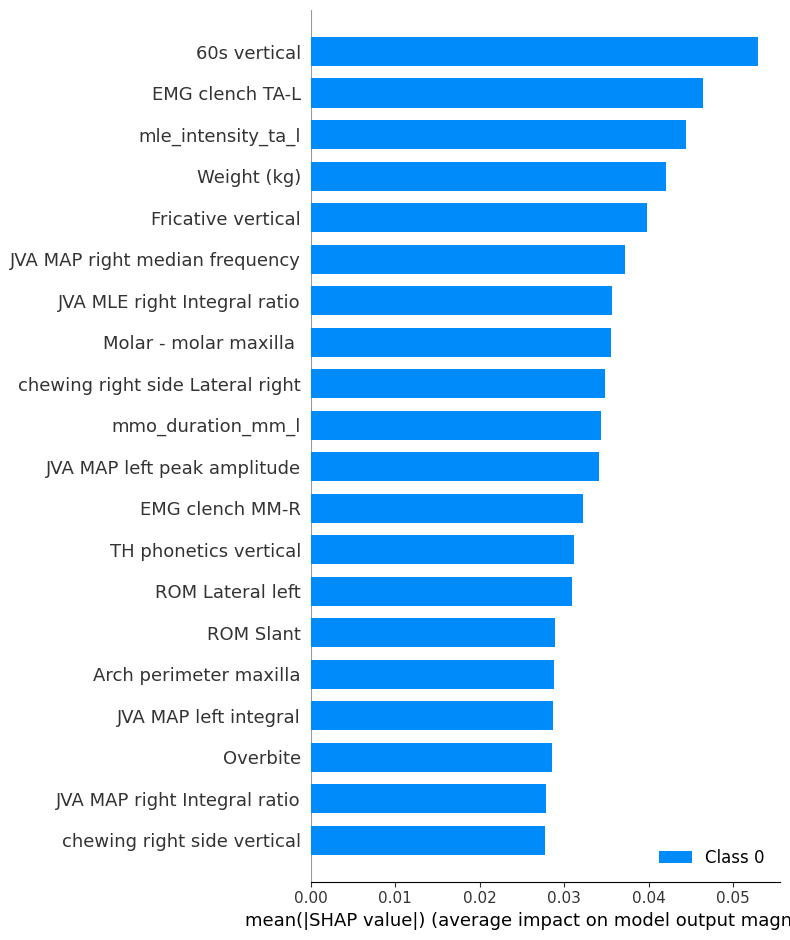

In [631]:
# plot the feature attributions
column_names = list(train_numeric.columns) + \
    list(train_categorical_encoded.columns)
shap.summary_plot(shap_values,
                  column_names)

In [632]:
# Get the average SHAP values across all observations
average_shap_values = np.mean(np.abs(shap_values[0]),
                              axis=0)
shap_value_df = pd.DataFrame({
    "Predictor": column_names,
    "SHAP value": average_shap_values
})

# Save SHAP df
shap_value_df.sort_values(by="SHAP value",
                          ascending=False,
                          inplace=True)
shap_value_df.to_csv("shap_values.csv",
                     index=False)

In [623]:
train_categorical_encoded.columns

Index(['Ethnicity_asian', 'Ethnicity_caucasian', 'Ethnicity_indian',
       'Gender_female', 'Gender_male', 'Clicking_no', 'Clicking_yes',
       'Lockout_no', 'Lockout_yes', 'Jaw pain (in last 2 years)_no',
       'Jaw pain (in last 2 years)_yes', 'Jaw Injuries_no', 'Jaw Injuries_yes',
       'Jaw clenching_no', 'Jaw clenching_yes', 'Bruxism_no', 'Bruxism_yes',
       'Sleep apnoea/snoring_no', 'Sleep apnoea/snoring_yes',
       'nail or object biting_no', 'nail or object biting_yes',
       'Dry/ sticky mouth_no', 'Dry/ sticky mouth_yes', 'chapped lips_no',
       'chapped lips_yes', 'increased thirst_no', 'increased thirst_yes',
       'dysphagia_no', 'dysphagia_yes', 'Dental filling in 2 years_no',
       'Dental filling in 2 years_yes', 'RCTs/crowns in 2 years_no',
       'RCTs/crowns in 2 years_yes', 'Orthodontic treatment_no',
       'Orthodontic treatment_yes', 'blocked nose_no', 'blocked nose_yes',
       'Lisp_no', 'Lisp_yes', 'Stammering_no', 'Stammering_yes',
       'Vit D 

#### Test results

In [586]:
test_results = pd.DataFrame({
    "Test RMSE": [test_results_lr_rmse,
                  test_results_rf_rmse,
                  test_results_cb_rmse,
                  test_results_xgb_rmse,
                  test_results_mlp_rmse,
                  test_results_tabnet_rmse],
    "Test MAE": [test_results_lr_mae,
                 test_results_rf_mae,
                 test_results_cb_mae,
                 test_results_xgb_mae,
                 test_results_mlp_mae,
                 test_results_tabnet_mae]
})
test_results.index = ["Linear Regression",
                      "Random Forest",
                      "Catboost Regressor",
                      "XGBoost Regressor",
                      "Multilayer Perceptron",
                      "Tabnet"]

test_results.to_csv(
    "test_results_with_phonetics_and_other_jva_data_4.csv")